In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

In [6]:
with open('../data/crypto_currency.pickle', 'rb') as f:
    data = pickle.load(f)

In [7]:
btt = data['KRW-BTT']

In [8]:
btt.tail()

,market,candle_date_time_utc,candle_date_time_kst,opening_price,high_price,low_price,trade_price,timestamp,candle_acc_trade_price,candle_acc_trade_volume,prev_closing_price,change_price,change_rate,MA5,MA20,MA60
4,KRW-BTT,2022-02-24T00:00:00,2022-02-24T09:00:00,0.0023,0.0024,0.0021,0.0023,1645747198314,1.862725e+10,8.399094e+12,0.0023,NaN,0.000000,0.00234,0.002580,0.002811
3,KRW-BTT,2022-02-25T00:00:00,2022-02-25T09:00:00,0.0023,0.0024,0.0022,0.0023,1645833598450,1.471682e+10,6.413362e+12,0.0023,NaN,0.000000,0.00232,0.002555,0.002792
2,KRW-BTT,2022-02-26T00:00:00,2022-02-26T09:00:00,0.0023,0.0024,0.0023,0.0023,1645919999557,6.547601e+09,2.754282e+12,0.0023,NaN,0.000000,0.00230,0.002530,0.002777
1,KRW-BTT,2022-02-27T00:00:00,2022-02-27T09:00:00,0.0023,0.0024,0.0022,0.0023,1646006399489,6.989035e+09,3.029290e+12,0.0023,NaN,0.000000,0.00230,0.002500,0.002760
0,KRW-BTT,2022-02-28T00:00:00,2022-02-28T09:00:00,0.0023,0.0025,0.0022,0.0025,1646092799469,1.149322e+10,4.915564e+12,0.0023,0.0002,0.086957,0.00234,0.002485,0.002745


In [9]:
btt.set_index('candle_date_time_kst', inplace = True)

Text(0, 0.5, 'price')

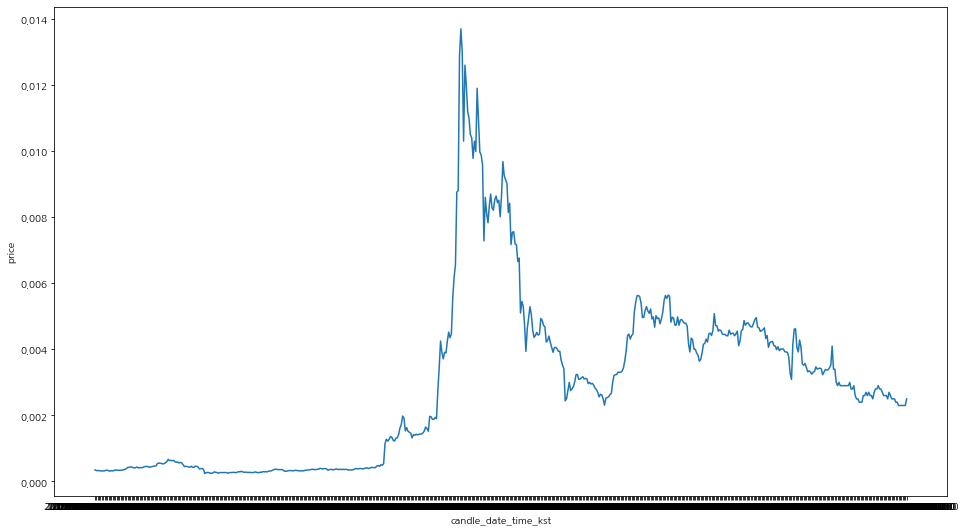

In [10]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=btt['trade_price'], x=btt.index)
plt.xlabel('candle_date_time_kst')
plt.ylabel('price')

In [11]:
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
# scale_cols = ['change_rate', 'candle_acc_trade_volume', 'trade_price']
scale_cols = ['trade_price']
# 스케일 후 columns
scaled = scaler.fit_transform(btt[scale_cols])

In [12]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('trade_price', 1), df['trade_price'], test_size=0.2, random_state=0, shuffle=False)

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [15]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [16]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [18]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [19]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'btt_ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [20]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
     12/Unknown - 2s 11ms/step - loss: 0.0330 - mse: 0.0660
Epoch 1: val_loss improved from inf to 0.01173, saving model to tmp/btt_ckeckpointer.ckpt
15/15 [==============================] - 4s 95ms/step - loss: 0.0331 - mse: 0.0663 - val_loss: 0.0117 - val_mse: 0.0235
Epoch 2/50
11/15 [=====================>........] - ETA: 0s - loss: 0.0221 - mse: 0.0443
Epoch 2: val_loss improved from 0.01173 to 0.00455, saving model to tmp/btt_ckeckpointer.ckpt
15/15 [==============================] - 0s 18ms/step - loss: 0.0212 - mse: 0.0424 - val_loss: 0.0046 - val_mse: 0.0091
Epoch 3/50
11/15 [=====================>........] - ETA: 0s - loss: 0.0119 - mse: 0.0238
Epoch 3: val_loss improved from 0.00455 to 0.00073, saving model to tmp/btt_ckeckpointer.ckpt
15/15 [==============================] - 0s 18ms/step - loss: 0.0119 - mse: 0.0237 - val_loss: 7.2613e-04 - val_mse: 0.0015
Epoch 4/50
11/15 [=====================>........] - ETA: 0s - loss: 0.0068 - mse: 0.0135
Epoch 4: val_loss im

In [21]:
model.load_weights(filename)

In [22]:
pred = model.predict(test_data)

In [23]:
pred.shape

(100, 1)

## Plot result

In [24]:
pred_plot = np.concatenate((np.expand_dims(y_train, axis = 1), np.zeros((20, 1)), pred))
# tmp_pred_plot = np.concatenate([np.concatenate([x_train, x_test]), pred_plot], axis = 1)
pred_plot = scaler.inverse_transform(pred_plot)
actual_plot = np.expand_dims(np.concatenate((y_train, y_test)), axis = 1)
# tmp_actual_plot = np.concatenate([np.concatenate([x_train, x_test]), actual_plot], axis = 1)
actual_plot = scaler.inverse_transform(actual_plot)

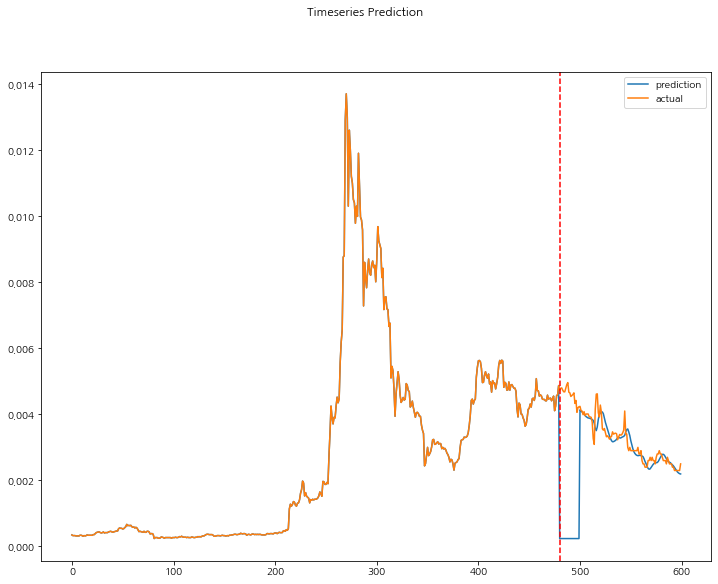

In [25]:
plt.figure(figsize=(12, 9))
plt.plot(pred_plot, label='prediction')
plt.plot(actual_plot, label='actual')
plt.axvline(x = y_train.shape[0], c = 'r', linestyle = '--')
plt.suptitle('Timeseries Prediction')
plt.legend()
plt.show()

### OOT test

In [26]:
import pickle 

with open('../data/crypto_currency_oot.pickle', 'rb') as f:
    oot_data = pickle.load(f)

In [27]:
data['KRW-BTT'].tail()['trade_price']

candle_date_time_kst
2022-02-24T09:00:00    0.0023
2022-02-25T09:00:00    0.0023
2022-02-26T09:00:00    0.0023
2022-02-27T09:00:00    0.0023
2022-02-28T09:00:00    0.0025
Name: trade_price, dtype: float64

In [35]:
oot_btt.shape

(60,)

In [36]:
oot_btt = oot_data['KRW-BTT']
oot_btt = np.concatenate([data['KRW-BTT'].tail(20)['trade_price'], oot_btt['trade_price']])
oot_scaled = scaler.transform(np.expand_dims(oot_btt, axis = 1))

In [46]:
oot_test_data = windowed_dataset(oot_scaled, WINDOW_SIZE, BATCH_SIZE, False)


In [47]:
oot_pred = model.predict(oot_test_data)

In [48]:
oot_pred.shape

(40, 1)

In [49]:
oot_pred_plot = np.concatenate((np.expand_dims(y_train, axis = 1), np.zeros((WINDOW_SIZE, 1)), pred, oot_pred))
oot_pred_plot = scaler.inverse_transform(oot_pred_plot)
oot_actual_plot = np.expand_dims(np.concatenate((y_train, y_test, oot_scaled.squeeze()[WINDOW_SIZE:])), axis = 1)
oot_actual_plot = scaler.inverse_transform(oot_actual_plot)

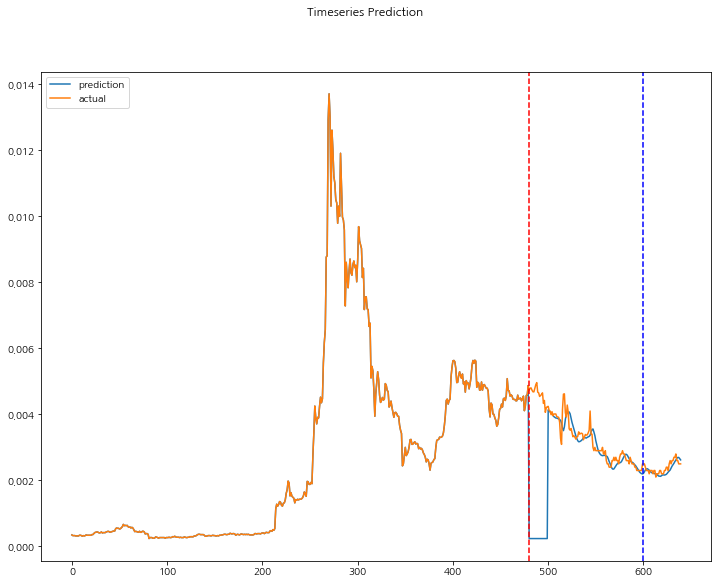

In [50]:
plt.figure(figsize=(12, 9))
plt.plot(oot_pred_plot, label='prediction')
plt.plot(oot_actual_plot, label='actual')
plt.axvline(x = y_train.shape[0], c = 'r', linestyle = '--')
plt.axvline(x = y_train.shape[0] + y_test.shape[0], c = 'b', linestyle = '--')
plt.suptitle('Timeseries Prediction')
plt.legend()
plt.show()